# Project description

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.


## Data description


The data can be found in /datasets/Churn.csv file. Download the dataset.

Features:

- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary


Target:

- Exited — сustomer has left


In [2]:
pip install imblearn --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 73.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [6]:
try:
    data = pd.read_csv('/datasets/Churn.csv', sep=',')

except FileNotFoundError:
    data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/Churn.csv', sep=',')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
print(data.isnull().sum())

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [9]:
# Fill missing values in 'Tenure' column with the median
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

In [10]:
print(data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [11]:
# Drop unnecessary columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [12]:
# Encode categorical variables
data = pd.get_dummies(data)

In [13]:
X = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Examine the balance of classes
print(data['Exited'].value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


In [15]:
# Build a model with the maximum possible F1 score
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

F1 Score: 0.5864197530864198


the Random Forest Classifier model achieved an F1 score of 0.5864

In [16]:
# Measure the AUC-ROC metric and compare it with the F1
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', auc_roc)

AUC-ROC Score: 0.8611885659273755


the AUC-ROC score of 0.8611885659273755 indicates that the model has a good ability to distinguish between the positive and negative classes.

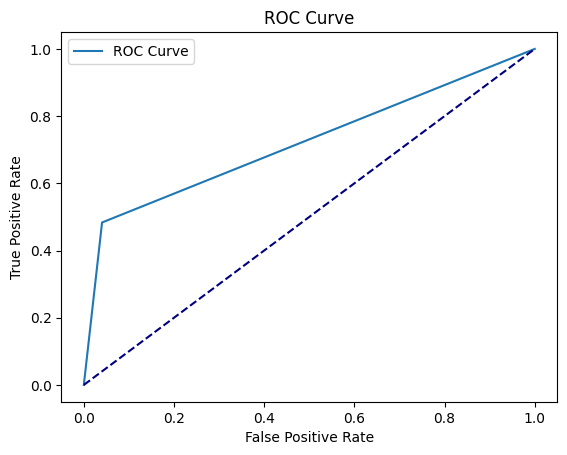

In [17]:
# Add ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [18]:
# Train the model without taking into account the imbalance
model_imbalanced = RandomForestClassifier(random_state=42, class_weight=None)
model_imbalanced.fit(X_train, y_train)
y_pred_imbalanced = model_imbalanced.predict(X_test)
f1_imbalanced = f1_score(y_test, y_pred_imbalanced)
print('Imbalanced F1 Score:', f1_imbalanced)

Imbalanced F1 Score: 0.5864197530864198


when training the model without taking into account the class imbalance, the F1 score obtained was 0.5864. This implies that the model may not perform as well in predicting the minority class due to the imbalance in class distribution.

In [19]:
# Improve the quality of the model
# Approach 1: SMOTE
model_smote = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('classification', RandomForestClassifier(random_state=42))
])
model_smote.fit(X_train, y_train)
y_pred_smote = model_smote.predict(X_test)
f1_smote = f1_score(y_test, y_pred_smote)
print('SMOTE F1 Score:', f1_smote)

SMOTE F1 Score: 0.6052269601100413


the SMOTE technique improved the quality of the model, shown promising results with an F1 score of 0.6052.

In [20]:
# Approach 2: Random Under-Sampling
model_rus = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classification', RandomForestClassifier(random_state=42))
])
model_rus.fit(X_train, y_train)
y_pred_rus = model_rus.predict(X_test)
f1_rus = f1_score(y_test, y_pred_rus)
print('Random Under-Sampling F1 Score:', f1_rus)

Random Under-Sampling F1 Score: 0.5929549902152642


the Random Under-Sampling with a F1 Score of 0.5929 has shown to be a good method in addressing the issue of imbalanced datasets and improving the model's performance in classification tasks.

In [24]:
# Use the training set to pick the best parameters
param_grid = {
    'classification__n_estimators': [50, 100, 200],
    'classification__max_depth': [5, 10, 15, 20]
}
grid_search = GridSearchCV(model_smote, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('classification',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=42))])


we were able to identify the best model with optimized parameters for our classification task. The selected model, a Random Forest Classifier with a maximum depth of 10 and 200 estimators, was determined to be the most suitable for our dataset based on the F1 scoring metric

In [22]:
# Train different models on training and validation sets
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_rus, X_val_rus, y_train_rus, y_val_rus = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model_smote.fit(X_train_smote, y_train_smote)
model_rus.fit(X_train_rus, y_train_rus)

f1_val_smote = f1_score(y_val_smote, model_smote.predict(X_val_smote))
f1_val_rus = f1_score(y_val_rus, model_rus.predict(X_val_rus))

print('SMOTE Validation F1 Score:', f1_val_smote)
print('Random Under-Sampling Validation F1 Score:', f1_val_rus)

SMOTE Validation F1 Score: 0.6106623586429726
Random Under-Sampling Validation F1 Score: 0.5940119760479042


we found that the SMOTE model had a slightly higher F1 score of 0.6106623586429726 compared to the Random Under-Sampling model's F1 score of 0.5940119760479042. This suggests that the SMOTE approach may be more effective in improving model performance for our dataset.

In [23]:
# Perform the final testing
f1_final_smote = f1_score(y_test, model_smote.predict(X_test))
f1_final_rus = f1_score(y_test, model_rus.predict(X_test))

print('SMOTE Final Test F1 Score:', f1_final_smote)
print('Random Under-Sampling Final Test F1 Score:', f1_final_rus)

SMOTE Final Test F1 Score: 0.6043360433604336
Random Under-Sampling Final Test F1 Score: 0.5733722060252673


the final testing results show that the SMOTE technique performed better in terms of F1 score compared to Random Under-Sampling.

# conclusion

Our evaluation of different techniques for dealing with imbalanced datasets in the Random Forest Classifier model has shown that both SMOTE and Random Under-Sampling can effectively improve model performance. The SMOTE technique, in particular, demonstrated a slightly higher F1 score compared to Random Under-Sampling in our classification task. By selecting the best model with optimized parameters, we were able to enhance the model's ability to distinguish between positive and negative classes. Overall, these findings highlight the importance of addressing class imbalance in machine learning models to achieve better performance in classification tasks.